# Brain f-MRI Image Classification of Alzheimer's Diagnosis Using Deep Learning Modeling CNNs

## Imports

In [1]:
import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np
from tensorflow.keras import datasets, layers, models, regularizers
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
%matplotlib inline

In [2]:
from numpy.random import seed
seed(72)
import tensorflow as tf
tf.random.set_seed(72)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Splitting Dataset

In [4]:
data = tf.keras.preprocessing.image_dataset_from_directory(
    directory='/content/drive/MyDrive/data',
    batch_size=6400,
    seed=42,
    image_size=(256, 256)
)

Found 6400 files belonging to 2 classes.


In [5]:
images, labels = next(iter(data))

In [6]:
images, labels = np.array(images), np.array(labels)

In [7]:
images.shape

(6400, 256, 256, 3)

In [8]:
labels.shape

(6400,)

In [9]:
train_images, test_images, train_labels, test_labels = train_test_split(images,
                                                                        labels,
                                                                        test_size=0.3,
                                                                        random_state=42)

In [10]:
test_images, val_images, test_labels, val_labels = train_test_split(test_images,
                                                                    test_labels,
                                                                    random_state=42,
                                                                    test_size=0.5)

In [11]:
input_layer = (256,256,3)

Normalizing images

In [12]:
train_images, test_images, val_images = train_images/255, test_images/255, val_images/255

Functions

In [13]:
# class FalsePositiveRate(tf.keras.metrics.Metric):
#     def __init__(self, name='false_positive_rate', threshold=0.5, **kwargs):
#         super(FalsePositiveRate, self).__init__(name=name, **kwargs)
#         self.negatives = self.add_weight(name='negatives', initializer='zeros')
#         self.false_positives = self.add_weight(name='false_negatives', initializer='zeros')
#         self.threshold = threshold
        
#     def update_state(self, y_true, y_pred, sample_weight=None):
#         '''
#         Arguments:
#         y_true  The actual y. Passed by default to Metric classes.
#         y_pred  The predicted y. Passed by default to Metric classes.
        
#         '''
#         # Compute the number of negatives.
#         y_true = tf.cast(y_true, tf.bool)
        
#         negatives = tf.reduce_sum(tf.cast(tf.equal(y_true, False), self.dtype))
        
#         self.negatives.assign_add(negatives)
        
#         # Compute the number of false positives.
#         y_pred = tf.greater_equal(y_pred, self.threshold)

In [14]:
def evaluate(model, name, history, X, y, threshold=0.5):
    
    print(f"Results for {name} with threshold = {threshold}.")
    
    plt.rcParams.update({'font.size': 18})
    #Create a function that provides useful vis for model
    #performance. This is especially useful as we are most
    #concerned with the number of false negatives
    
    train_loss=[value for key, value in history.items() if 'loss' in key.lower()][0]
    valid_loss=[value for key, value in history.items() if 'loss' in key.lower()][1]
    train_auc=[value for key, value in history.items() if 'auc' in key.lower()][0]
    valid_auc=[value for key, value in history.items() if 'auc' in key.lower()][1]
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(25, 15))

    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.plot(train_loss, color='tab:blue', label='Train Loss')
    ax1.plot(valid_loss, color='tab:orange', label='Valid Loss')
    ax1.legend(loc='upper left')
    ax1.set_ylim([0,1.05])
    plt.title('Model Loss')

    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('AUC')
    ax2.plot(train_auc, color='tab:blue', label='Train AUC')
    ax2.plot(valid_auc, color='tab:orange', label='Valid AUC')
    ax2.legend(loc='upper left')
    ax2.set_ylim([0.5,1.05])
    plt.title('Model AUC')
        
    y_pred = model.predict(X)
    y_pred_adjusted = np.zeros([len(y), ])
    i=0
    for pred in y_pred:
        if pred > threshold:
            y_pred_adjusted[i] = 1
            i+=1
        else:
            y_pred_adjusted[i] = 0
            i+=1

    cm = confusion_matrix(y, y_pred_adjusted)
    cm_df = pd.DataFrame(cm)

    sns.heatmap(cm, ax=ax3, annot=True, cmap='Blues', fmt='0.7g') 

    plt.sca(ax3)
    plt.xlabel('Predicted Values')
    plt.ylabel('True Values')
    
    train_recall=[value for key, value in history.items() if 'recall' in key.lower()][0]
    valid_recall=[value for key, value in history.items() if 'recall' in key.lower()][1]
    train_precision=[value for key, value in history.items() if 'precision' in key.lower()][0]
    valid_precision=[value for key, value in history.items() if 'precision' in key.lower()][1]
    
    if (cm_df[0][1] == 0) or (cm_df[1][1] ==0):
        train_f1 = 'N/A'
        valid_f1 = 'N/A'
    else:
        train_f1 = 2*(train_recall[-1]*train_precision[-1])/(train_recall[-1]+train_precision[-1])
        valid_f1 = 2*(valid_recall[-1]*valid_precision[-1])/(valid_recall[-1]+valid_precision[-1])
    
    print(f"\n Train f1: {train_f1} \n Val f1: {valid_f1} \n\n Train Recall: {train_recall[-1]} \n Val Recall: {valid_recall[-1]}")

    ax4.set_xlabel('Epoch')
    ax4.set_ylabel('Recall')
    ax4.set_ylim([-0.05,1.05])
    ax4.plot(train_recall, '--', color='tab:orange', label='Train Recall')
    ax4.plot(valid_recall, color='tab:orange', label='Valid Recall')
    ax4.legend(loc='lower left')
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()

Modeling

In [15]:
# model1 = models.Sequential()
# model1.add(layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=(input_layer)))
# model1.add(layers.Dense(32, activation='relu'))
# model1.add(layers.Dense(1, activation='sigmoid'))

In [16]:
model1 = models.Sequential([
    # since Conv2D is the first layer of the neural network, we should also specify the size of the input
    layers.Conv2D(128, (3,3), activation='relu', input_shape=(input_layer)),
    # apply pooling
    layers.MaxPooling2D(2,2),
    # flatten the result to feed it to the dense layer
    layers.Flatten(), 
    # and define 512 neurons for processing the output coming by the previous layers
    layers.Dense(512, activation='relu'),
    # dropout layer
    layers.Dropout(0.5),
    # a single output neuron
    layers.Dense(1, activation='sigmoid')  
])

In [17]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 128)     3584      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 128)    0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 2064512)           0         
                                                                 
 dense (Dense)               (None, 512)               1057030656
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 513       
                                                        

In [18]:
metrics = ['accuracy', 'AUC', tf.keras.metrics.Recall(), tf.keras.metrics.Precision()]

In [19]:
metrics

['accuracy',
 'AUC',

In [20]:
model1.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=metrics)

In [21]:
history=model1.fit(train_images, 
                  train_labels,
                  epochs=10,
                  validation_data=(val_images,val_labels),
                  verbose=2
                  ).history

Epoch 1/10
140/140 - 15s - loss: 2.4096 - accuracy: 0.6096 - auc: 0.6330 - recall: 0.5838 - precision: 0.6176 - val_loss: 0.6665 - val_accuracy: 0.5688 - val_auc: 0.7930 - val_recall: 0.1540 - val_precision: 0.9740 - 15s/epoch - 104ms/step
Epoch 2/10
140/140 - 9s - loss: 0.5278 - accuracy: 0.7395 - auc: 0.8162 - recall: 0.7554 - precision: 0.7336 - val_loss: 0.4111 - val_accuracy: 0.8240 - val_auc: 0.9155 - val_recall: 0.8070 - val_precision: 0.8397 - 9s/epoch - 65ms/step
Epoch 3/10
140/140 - 9s - loss: 0.3274 - accuracy: 0.8665 - auc: 0.9401 - recall: 0.8644 - precision: 0.8690 - val_loss: 0.2955 - val_accuracy: 0.8792 - val_auc: 0.9503 - val_recall: 0.8563 - val_precision: 0.9006 - 9s/epoch - 65ms/step
Epoch 4/10
140/140 - 9s - loss: 0.1864 - accuracy: 0.9359 - auc: 0.9827 - recall: 0.9364 - precision: 0.9360 - val_loss: 0.2088 - val_accuracy: 0.9125 - val_auc: 0.9760 - val_recall: 0.8871 - val_precision: 0.9371 - 9s/epoch - 65ms/step
Epoch 5/10
140/140 - 9s - loss: 0.1042 - accuracy

Results for model with threshold = 0.5.
30/30 [==============================] - 1s 16ms/step

 Train f1: 0.9988891217068893 
 Val f1: 0.9805924515015667 

 Train Recall: 0.9995553493499756 
 Val Recall: 0.9856262803077698


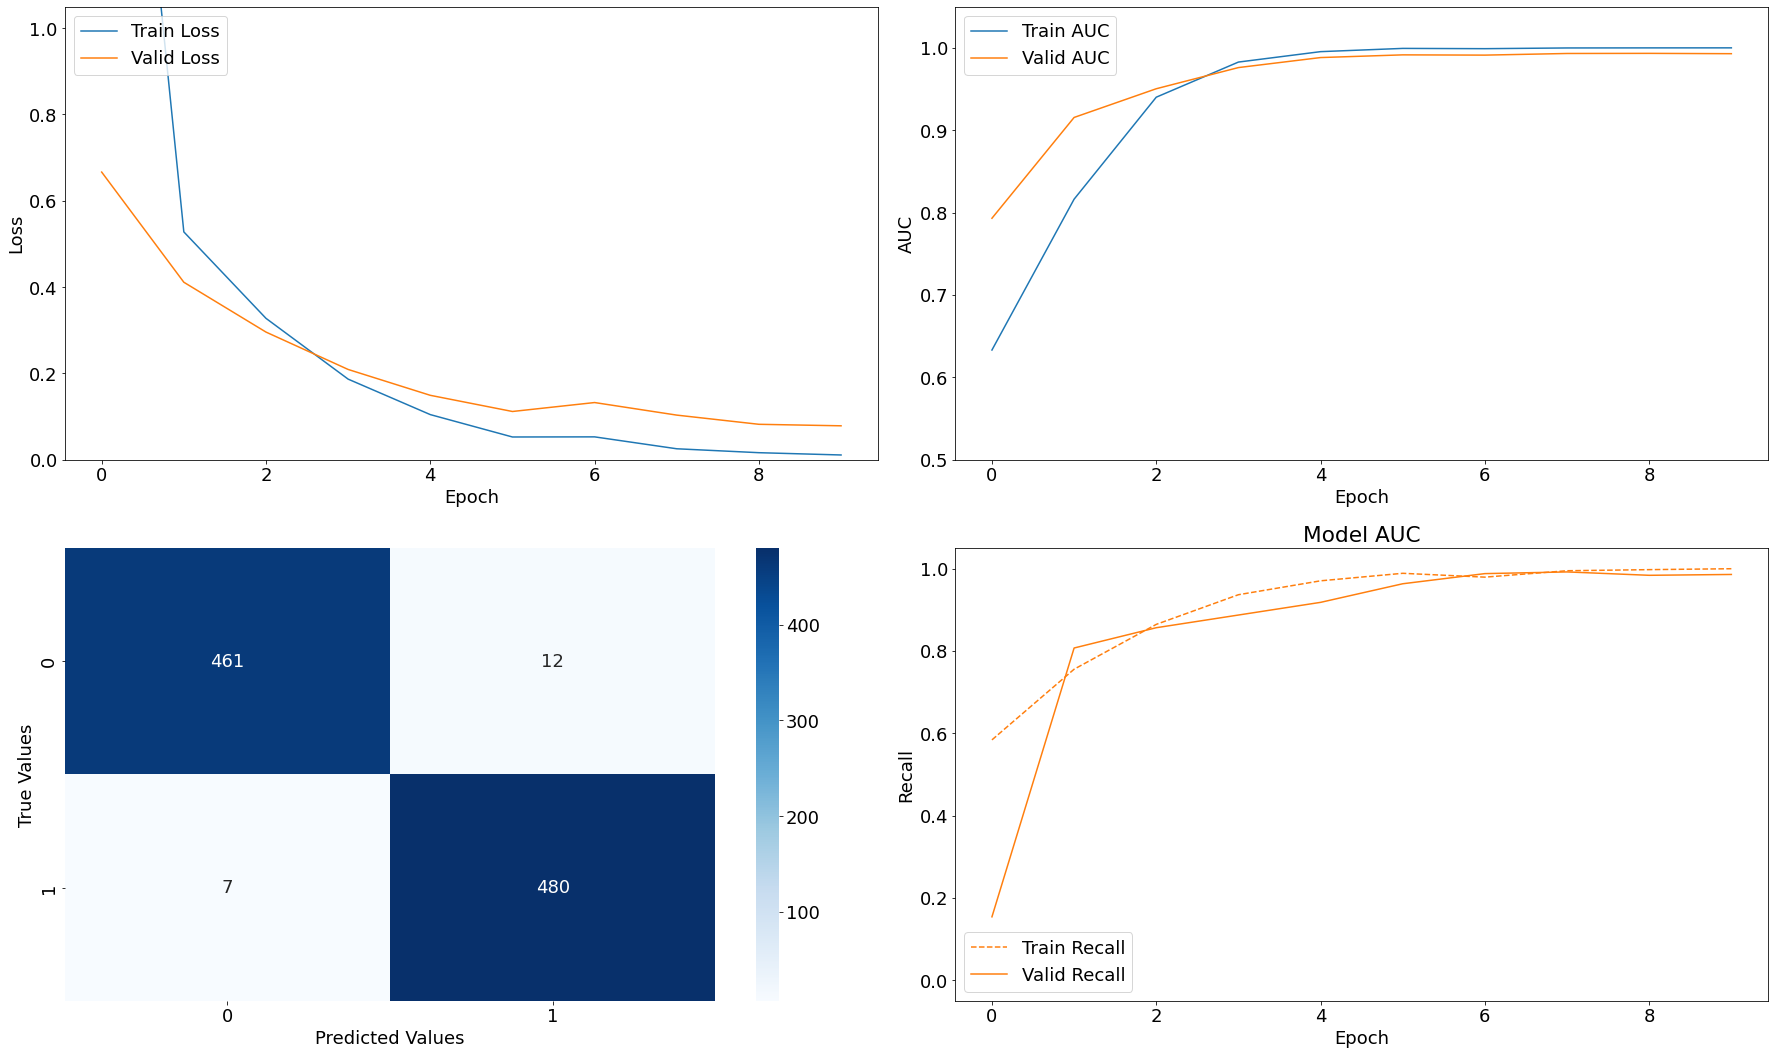

In [23]:
evaluate(model1, 'model', history, X=val_images, y=val_labels, threshold=0.5)